# Residential Solar Panel Size Prediction

Author: Sayantan Mitra<br>
Chief Data Scientist, Compton & Wendler<br>
Ph.D. candidate, Baylor College of Medicine

#### ► <span  style="color:blue; font-size:15px"> Objective: Predict size of solar panels for residential setting</span>

# 1.A. Import libraries and load data 

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

# VisualiZation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Data selected as discussed in Part_1 notebook for data exploration

In [2]:
solar = pd.read_csv('solar_sizepred.csv', parse_dates=['date_installed']) 
# Range of residential is upto 40kWh generally
filt1 = solar['install_type'] == 'residential'
filt2 = (solar['size_kw'] > 0) & (solar['size_kw'] < 40)
solar = solar[filt1 & filt2]

# All residential so drop column 'install_type' # only keeping columns relevant to user input
solar = solar.drop(columns=['install_type', 'incentive_prog_names', 'annual_insolation',
                           'tracking_type'])
solar.head()

,state,date_installed,size_kw,zipcode,installer,city,tech_1,county,annual_PV_prod
0,TX,2013-12-12,10.56,78702,NaN,AUSTIN,Poly,Travis,14999.831600
1,TX,2014-07-11,12.72,78702,NaN,AUSTIN,Mono,Travis,17811.574390
2,TX,2014-01-17,5.40,78702,NaN,AUSTIN,Mono,Travis,7833.742822
3,TX,2012-09-27,7.50,78702,NaN,AUSTIN,Poly,Travis,10151.709590
4,TX,2012-09-26,5.00,78702,NaN,AUSTIN,Poly,Travis,7307.133789


■ Detailed EDA for each feature is performed in `Part 1. SolarPanel_Data_Exploration`.

# 1.B. Feature Engineering

In [3]:
# Zipcode: extract initial number of zipcode 
solar['zipcode_1'] = solar['zipcode'].astype('str').str[:1].astype(int)
# DateTime column: extract year and month of installation
date = solar['date_installed']
solar['year'] = date.dt.year.astype('str')

# Divide data into train and test # Use this test as a validation set later on
from sklearn.model_selection import train_test_split
solar_train, solar_val = train_test_split(solar, test_size=0.2, random_state= 0)
solar = solar_train

### Cardinality reduction

► Unique values in some categorical columns such as `installer`, `city`, `county`, etc. are large. We need to apply the custom functions generated in Part_1 notebook to reduce cardinality.

In [4]:
def group_levels_in_categoricals(df, threshold=0.01, min_freq=0, max_freq=np.Inf):
    df0 = df.describe(include=['O']).T
    # reduced list is name of categorical columns
    reduced_list = df0[(df0.unique < max_freq) & (df0.unique > min_freq)].reset_index()['index'].tolist()
    
    #patterns will contain list of all categories of all categorical column whose occurance is more than threshold
    patterns = []
    other = []
    for col in reduced_list:
        df_normalized = df[col].value_counts(normalize=True).reset_index()
        df_normalized.columns = ['col_name', 'normalized_value']
        filt = df_normalized['normalized_value'] > threshold
        # norm_list contains all the categories in a categorical column whose occurance is more than threshold    
        norm_list = df_normalized[filt]['col_name'].tolist()
        pattern = norm_list
        patterns.append(norm_list)
        # selecting categories that are present less than threshold
        others_list = df_normalized[~filt]['col_name'].tolist()
        other.append(others_list)
        
        if pattern != []: 
            df[col] = df[col].replace({x:'Other' for x in others_list})
        else:
            df.drop(col, inplace=True, axis=1)
    return (df, patterns, reduced_list, other)

df, patterns, reduced_list, other = group_levels_in_categoricals(solar)
# solar training set after transformation
solar.describe(include=['O']).T

,count,unique,top,freq
state,389802,12,CA,209433
installer,340232,11,Other,179191
city,389802,7,Other,354837
tech_1,304226,5,Poly,175819
county,389802,23,Other,125813
year,389802,10,2015,141984


In [5]:
# We have to keep this consistent with test data as well
def group_levels_in_categoricals_test(reduced_list, other, patterns, df_test):   
    for idx, col in enumerate(reduced_list):       
        if other[idx] != []:
            filt = df_test[col].isin(patterns[idx])
            df_test[col][~filt]='Others'
        else:
            df_test.drop(col, inplace=True, axis=1)       
    return df_test

solar_val = group_levels_in_categoricals_test(reduced_list, other, patterns, solar_val)
# solar validation set after transformation
solar_val.describe(include=['O']).T

,count,unique,top,freq
state,97451,12,CA,52440
installer,97451,11,Others,57231
city,97451,7,Others,88833
tech_1,97451,5,Poly,44016
county,97451,23,Others,31327
year,97451,10,2015,35686


♦ Solar train and test set categorical columns have the same number of unique values.

# 1.C. Feature transformation
Based on EDA in Part_1 notebook, we have to transform the target i.e. `size_kw` and `annual_PV_prod`

In [6]:
# Target(size_kw) transformation
solar['size_kw_L'] = np.log1p(solar['size_kw'])
solar_val['size_kw_L'] = np.log1p(solar_val['size_kw'])

# annual_PV_prod transformation
solar['annual_PV_prod_L'] = np.log1p(solar['annual_PV_prod'])
solar_val['annual_PV_prod_L'] = np.log1p(solar_val['annual_PV_prod'])
# Feature emgineering
solar['annual_PV_prod_L-s2'] = solar['annual_PV_prod_L']** 2
solar_val['annual_PV_prod_L-s2'] = solar_val['annual_PV_prod_L']** 2

# Transforming some numerical variables that are actually categorical
solar['zipcode_1'] = solar['zipcode_1'].apply(str)
solar_val['zipcode_1'] = solar_val['zipcode_1'].apply(str)

# Categorical encoding
solar1 = pd.get_dummies(solar)
solar_val = pd.get_dummies(solar_val)
solar1.shape, solar_val.shape

((389802, 83), (97451, 83))

# 2. Predictive Modeling

In [7]:
# Separate dependent and independent variables
# Dependent variable
y_L = solar1['size_kw_L']
y_val_L = solar_val['size_kw_L']

# Independent variable
solar1 = solar1.drop(columns=['size_kw', 'size_kw_L', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L', 'date_installed']) 
solar_val = solar_val.drop(columns=['size_kw', 'size_kw_L', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L', 'date_installed'])                         

# Scaling for linear models or other models that calculate the distance
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
solar1_stndz = sc.fit_transform(solar1)
solar_val_stndz = sc.transform(solar_val)

# Use solar1_stndz and y_L for CV and train-test for normal evaluation
X_train,X_test,y_train,y_test = train_test_split(solar1_stndz, y_L, test_size = 0.3, random_state= 0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((272861, 77), (116941, 77), (272861,), (116941,))

In [8]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, make_scorer

# Additional validation function
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
# rmsle is an error, lower is better
rmsle_scorer = make_scorer(rmsle, greater_is_better=False) 

## Create a baseline to check model performance improvement

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)

dr = DummyRegressor()
dr.fit(X_train, y_train)
y_pred = dr.predict(X_test)

print(f'Dummy Regressor_r2: {r2_score(y_test, y_pred).round(4)}')
print(f'Dummy Regressor_mean_squared_error: {mean_squared_error(y_test, y_pred).round(4)}')
print(f'Dummy Regressor_RMSLE: {cross_val_score(dr, solar1_stndz, y_L, cv=kf, \
      scoring=rmsle_scorer).mean().round(4)}')

Dummy Regressor_r2: -0.0
Dummy Regressor_mean_squared_error: 0.1855
Dummy Regressor_RMSLE: -0.1554


## 2.A. Linear Regression without regularization

In [10]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f'Linear Regression_r2: {r2_score(y_test, y_pred).round(4)}')
print(f'Linear Regression_Mean_squared_error: {mean_squared_error(y_test, y_pred).round(4)}')

Linear Regression_r2: 0.9859
Linear Regression_Mean_squared_error: 0.0026


#### Linear Regression cross validation

In [11]:
scores = cross_val_score(lr, solar1_stndz, y_L, cv=5)
print(f'Linear regression_cv_r2: {scores.mean().round(4), scores.std().round(6)}')

kf = KFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(lr, solar1_stndz, y_L, cv=kf)
print(f'Linear regression_cv[with_shuffle]_r2: {scores.mean().round(4), scores.std().round(6)}')

nms_error = cross_val_score(lr, solar1_stndz, y_L, cv=kf, scoring='neg_mean_squared_error')
print(f'LR_cv[with_shuffle]_neg_mean_squared_error: {nms_error.mean().round(4), nms_error.std().round(6)}')

Linear regression_cv_r2: (0.9858, 0.000161)
Linear regression_cv[with_shuffle]_r2: (0.9858, 0.00013)
LR_cv[with_shuffle]_neg_mean_squared_error: (-0.0026, 2.7e-05)


Here we see the linear regression performs great. Cross-validation and cross-validation (shuffle, shuffle helps sometime when data is ordered) didn't improve the model, as model is already pretty good. 

Let's try regularized regression. We can also try lasso as it reduces feature space.

#### Linear Regression performance on validation set

In [12]:
y_pred = lr.predict(solar_val_stndz)
print(f'Linear Regression_r2_Validation_set: {lr.score(solar_val_stndz, y_val_L).round(6)}')
print(f'Linear Regression_mean_squared_error: {mean_squared_error(y_val_L, y_pred).round(6)}')

cv_score = cross_val_score(lr, solar_val_stndz, y_val_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation_r2: {cv_score.std().round(6)}')

Linear Regression_r2_Validation_set: 0.98557
Linear Regression_mean_squared_error: 0.002706
Overall model performance with cv_Mean_r2: 0.9857 
Overall model performance with cv_Std_deviation_r2: 0.000508


## 2.B. Linear Regression with Ridge regularization (L2 penalty)

In [13]:
# Regularized regression(ridge) without any tuning
rg = Ridge(alpha=1)
rg.fit(X_train, y_train)

print(f'Ridge Regression_r2: {rg.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(rg, solar1_stndz, y_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_r2_Std_deviation: {cv_score.std().round(6)}')

Ridge Regression_r2: 0.9859
Overall model performance with cv_Mean_r2: 0.9858 
Overall model performance with cv_r2_Std_deviation: 0.00013


#### Ridge regression hyperparameter tuning

Best_score: 0.985828
Ridge_best_alpha: 7.077011
Ridge Regression_r2: 0.9859
Overall model performance with cv_Mean_r2: 0.9858 
Overall model performance with cv_r2_Std_deviation: 0.00013


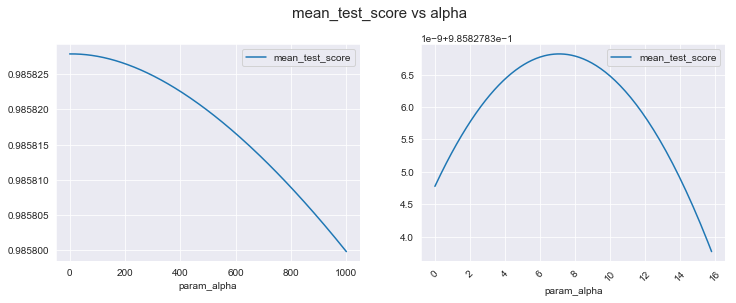

In [14]:
# Regularized regression(ridge) with hyperparameter tuning
alphas = np.logspace(-3, 3, num=1000) 
param_grid = {'alpha': alphas}
gs = GridSearchCV(rg, param_grid, cv=kf)
gs.fit(solar1_stndz, y_L)
print(f'Best_score: {(gs.best_score_).round(6)}') 
ridge_best_alpha = gs.best_params_['alpha']
print(f'Ridge_best_alpha: {ridge_best_alpha.round(6)}')

rg = Ridge(alpha=ridge_best_alpha)
rg.fit(X_train, y_train)
print(f'Ridge Regression_r2: {rg.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(rg, solar1_stndz, y_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_r2_Std_deviation: {cv_score.std().round(6)}')

df_results = pd.DataFrame(gs.cv_results_)
fig, axes = plt.subplots(1,2, figsize = (12,4))
df_results.plot(x='param_alpha', y='mean_test_score', ax=axes[0])
df_results[:700].plot(x='param_alpha', y='mean_test_score', ax=axes[1])
axes[1].xaxis.set_tick_params(rotation=45)
fig.suptitle('mean_test_score vs alpha', fontsize=15, y=1.01);

Model performs very well even without hyperparameter tuning. Above plot shows as penalty increases up to `Ridge_best_alpha`, mean_test_score improves. However, with more stringent penalty on the coefficients, mean_test_score drops.

#### Feature importance based on Ridge regression

Ridge picked 77 features and eliminated the other 0 features


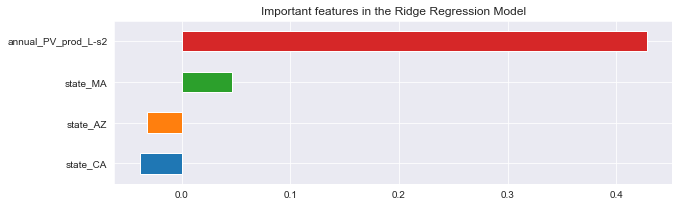

In [15]:
# Plot important coefficients
rg = Ridge(alpha=ridge_best_alpha)
rg.fit(X_train, y_train)
coefs = pd.Series(rg.coef_, index = solar1.columns)

print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(2), coefs.sort_values().tail(2)])
imp_coefs.plot(kind = "barh", figsize=(10, 3))
plt.title("Important features in the Ridge Regression Model")
plt.show()

→ As expected from EDA, `annual_PV_prod`'s derrivative is the most important feature for prediction.

#### Ridge regression performance with validation set

In [16]:
rg = Ridge(alpha=ridge_best_alpha)
rg.fit(X_train, y_train)
y_pred = rg.predict(solar_val_stndz)
print(f'Ridge Regression_r2_Validation_set: {rg.score(solar_val_stndz, y_val_L).round(6)}')
print(f'Ridge Regression_mean_squared_error: {mean_squared_error(y_val_L, y_pred).round(6)}')

cv_score = cross_val_score(rg, solar_val_stndz, y_val_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation_r2: {cv_score.std().round(6)}')

Ridge Regression_r2_Validation_set: 0.985582
Ridge Regression_mean_squared_error: 0.002704
Overall model performance with cv_Mean_r2: 0.9857 
Overall model performance with cv_Std_deviation_r2: 0.000507


►**Overall summary**<br>
→ Ridge regression performs great, however it doesn't improve beyond linear regression (as LR prediction was already great). 

→ **Next step**: The characteristic of ridge regression is that it reduces the coefficient close to 0 but NOT 0, thus it can't act as a feature selector unlike Lasso regression. Lasso helps to remove unwanted features. As we know there are some features which might not be very important to predict `size_kw` we should try Lasso.

## 2.C. Linear Regression with Lasso regularization (L1 penalty)

In [17]:
# Regularized regression(lasso) without any tuning
ls = Lasso(alpha=1)
ls.fit(X_train, y_train)

print(f'Lasso Regression_r2: {ls.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(ls, solar1_stndz, y_L, cv=kf)
print(f'Overall model performance with cv_Mean: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation: {cv_score.std().round(6)}')

Lasso Regression_r2: -0.0
Overall model performance with cv_Mean: -0.0001 
Overall model performance with cv_Std_deviation: 4.4e-05


Lasso performs poorly, we need to tune the `alpha` hyperparameter of lasso to improve its performance.

#### Lasso regression hyperparameter tuning

In [18]:
# Regularized regression(lasso) with hyperparameter tuning
alphas = np.logspace(-6, 0, 1000)  
param_grid = {'alpha': alphas}
gs = GridSearchCV(ls, param_grid, cv=kf)
gs.fit(solar1_stndz, y_L)
print(f'best_score: {(gs.best_score_).round(6)}')
lasso_best_alpha = gs.best_params_['alpha']
print(f'Lasso_best_alpha: {lasso_best_alpha.round(6)}')

# Regularized regression(lasso) with tuning
ls = Lasso(alpha = lasso_best_alpha)
ls.fit(X_train, y_train)
print(f'Lasso Regression_r2: {rg.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(ls, solar1_stndz, y_L, cv=kf)
print(f'Overall model performance with cv_Mean: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation: {cv_score.std().round(6)}')

best_score: 0.985828
Lasso_best_alpha: 1e-06
Lasso Regression_r2: 0.9859
Overall model performance with cv_Mean: 0.9858 
Overall model performance with cv_Std_deviation: 0.00013


#### Impact of alpha strength on the coefficient of the features in Lasso Regression 

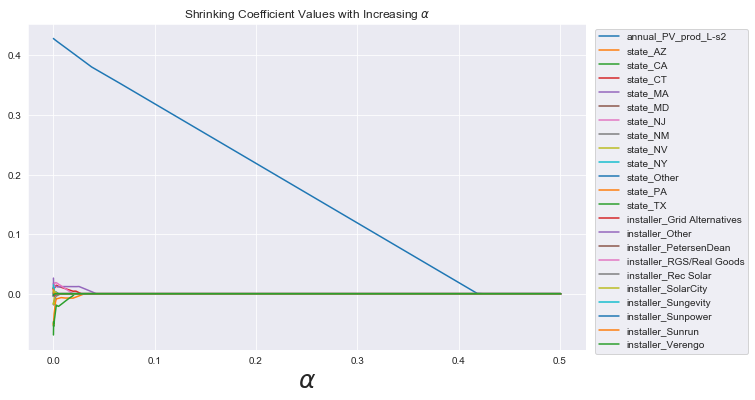

In [19]:
coefs = [] 
for alpha in alphas:
    ls = Lasso(alpha=alpha)
    ls.fit(X_train, y_train)
    coefs.append(ls.coef_)
df_coef = pd.DataFrame(index=alphas, data=np.array(coefs), columns=solar1.columns)

ax = df_coef.iloc[:950,:23].plot(figsize=(10, 6), title=r'Shrinking Coefficient Values with Increasing $\alpha$')
ax.legend(bbox_to_anchor=(1.3, 1))
ax.set_xlabel(r'$\alpha$', size=25);

#### Feature importance based on Lasso regression

Lasso picked 75 features and eliminated the other 2 features


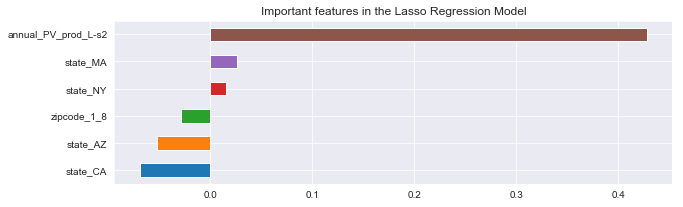

In [20]:
# Plot important coefficients
ls = Lasso(alpha = lasso_best_alpha)
ls.fit(X_train, y_train)
coefs = pd.Series(ls.coef_, index = solar1.columns)

print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(3), coefs.sort_values().tail(3)])
imp_coefs.plot(kind = "barh",figsize=(10, 3))
plt.title("Important features in the Lasso Regression Model")
plt.show()

→ As expected from EDA, `annual_PV_prod`'s derrivative is the most important feature for prediction (similar to ridge).

#### Lasso regression performance with validation set

In [21]:
ls = Lasso(alpha = lasso_best_alpha)
ls.fit(X_train, y_train)
y_pred = ls.predict(solar_val_stndz)
print(f'Lasso Regression_r2_Validation_set: {ls.score(solar_val_stndz, y_val_L).round(6)}')
print(f'Lasso Regression_mean_squared_error: {mean_squared_error(y_val_L, y_pred).round(6)}')

cv_score = cross_val_score(ls, solar_val_stndz, y_val_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation_r2: {cv_score.std().round(6)}')

Lasso Regression_r2_Validation_set: 0.985583
Lasso Regression_mean_squared_error: 0.002704
Overall model performance with cv_Mean_r2: 0.9857 
Overall model performance with cv_Std_deviation_r2: 0.000508


►**Overall summary**<br>
→ Lasso regression performs poorly without hyperparameter tuning.<br>

→ As alpha is tuned, lasso performance improves greatly. Lasso prediction performance is similar to ridge.<br>

→ There is however a benefit of lasso over ridge. In Lasso, as penalty increases the coefficient of some of the features become 0 and thus it acts as a feature selector. However, with the best alpha that we got from hyperparameter tuning, we observe that lasso removes only 2 features. If it reduces a significant number of features, Lasso could be chosen as the final model.

→ **Next step**: We run ridge when we don't want to completely eliminate a feature, lasso when we want it to remove unimportant features. But when we are not sure which one to chose (when there are too many features and we don't have time to do EDA in each one of them) we can run elastic net. I run elastic net just for fun as I have clear understanding of the features.

## 2.D. Linear Regression with ElasticNet regularization (L1 and L2 penalty)

In [22]:
# Regularized regression(ElasticNet) without any tuning
en= ElasticNet(alpha=1)
en.fit(X_train, y_train)

print(f'ElasticNet Regression_r2: {en.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(en, solar1_stndz, y_L, cv=kf)
print(f'Overall model performance with cv_Mean: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation: {cv_score.std().round(6)}')

ElasticNet Regression_r2: -0.0
Overall model performance with cv_Mean: -0.0001 
Overall model performance with cv_Std_deviation: 4.4e-05


ElasticNet performs poorly, we need to tune the alpha hyperparameter of ElasticNet to improve its performance.

In [23]:
# Regularized regression(ElasticNet) with hyperparameter tuning
from sklearn.model_selection import GridSearchCV
alphas = np.logspace(-6, 0, 100) 
param_grid = {'alpha': alphas}
gs = GridSearchCV(en, param_grid, cv=kf)
gs.fit(solar1_stndz, y_L) 
print(f'best_score: {(gs.best_score_).round(6)}')
en_best_alpha = gs.best_params_['alpha']
print(f'ElasticNet_best_alpha: {en_best_alpha.round(6)}')

# Regularized regression(ElasticNet) with tuning
en = ElasticNet(alpha = en_best_alpha)
en.fit(X_train, y_train)
print(f'ElasticNet Regression_r2: {en.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(en, solar1_stndz, y_L, cv=kf)
print(f'Overall model performance with cv_Mean: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation: {cv_score.std().round(6)}')

best_score: 0.985828
ElasticNet_best_alpha: 1e-06
ElasticNet Regression_r2: 0.9859
Overall model performance with cv_Mean: 0.9858 
Overall model performance with cv_Std_deviation: 0.00013


#### Impact of alpha strength on the coefficient of the features in ElasticNet

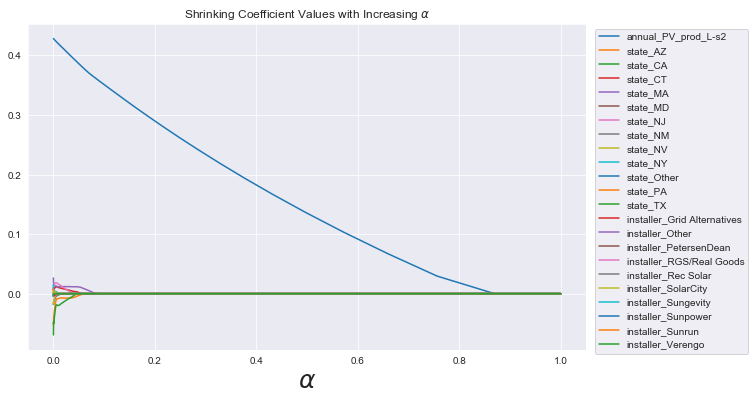

In [24]:
coefs = []
for alpha in alphas:
    en = ElasticNet(alpha=alpha)
    en.fit(X_train, y_train)
    coefs.append(en.coef_)
df_coef = pd.DataFrame(index=alphas, data=np.array(coefs), columns=solar1.columns)

ax = df_coef.iloc[:,:23].plot(figsize=(10, 6), title=r'Shrinking Coefficient Values with Increasing $\alpha$')
ax.legend(bbox_to_anchor=(1.3, 1))
ax.set_xlabel(r'$\alpha$', size=25);

#### Feature importance based on ElasticNet regression

ElasticNet picked 76 features and eliminated the other 1 features


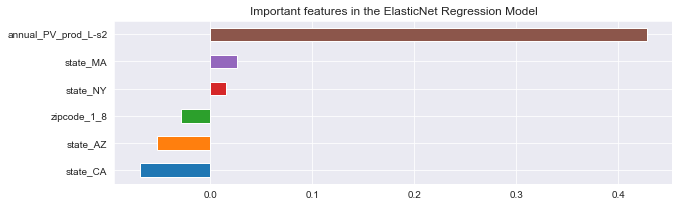

In [25]:
# Plot important coefficients
en = ElasticNet(alpha = en_best_alpha)
en.fit(X_train, y_train)
coefs = pd.Series(en.coef_, index = solar1.columns)

print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(3), coefs.sort_values().tail(3)])
imp_coefs.plot(kind = "barh",figsize=(10, 3))
plt.title("Important features in the ElasticNet Regression Model")
plt.show()

→ Annual energy production's derivative is the most important feature for prediction (similar to ridge & lasso).

#### ElasticNet regression performance with validation set

In [26]:
en = ElasticNet(alpha = en_best_alpha)
en.fit(X_train, y_train)
y_pred = en.predict(solar_val_stndz)
print(f'ElasticNet Regression_r2_Validation_set: {en.score(solar_val_stndz, y_val_L).round(6)}')
print(f'ElasticNet Regression_mean_squared_error: {mean_squared_error(y_val_L, y_pred).round(6)}')

cv_score = cross_val_score(en, solar_val_stndz, y_val_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation_r2: {cv_score.std().round(6)}')

ElasticNet Regression_r2_Validation_set: 0.985582
ElasticNet Regression_mean_squared_error: 0.002704
Overall model performance with cv_Mean_r2: 0.9857 
Overall model performance with cv_Std_deviation_r2: 0.000508


►**Overall summary**<br>
→ ElasticNet regression performs poorly without hyperparameter tuning.<br>

→ As alpha is tuned, ElasticNet performance improves greatly (similar to lasso). 

→ **Next step**: All the models perform well and show great performance with validation set. We can select either, but I will proceed with ridge regression as lasso is only eliminating 2 features.

In [28]:
# Save the model, for ridge alpha=1 performed well
rg = Ridge(alpha=1)
rg.fit(X_train, y_train)
from sklearn.externals import joblib
joblib.dump(rg, 'size_prediction_model.joblib');

This is the end of the SolarPanel size prediction <br>
→ Part_3 notebook will focus on predicting cost of the solar panels.